# Numerical Methods for some PDE:s

## 1. Contents

**Goals.** In this project, we will work with parabolic and hyperbolic partial differential equations, and combine elementary techniques from $2 \mathrm{p}$-BVPs with time-stepping methods from IVPs. The goal is to gain experience with the method of lines and stability constraints of Courant-Friedrichs-Lewy (CFL) type on the time-step $\Delta t$.

In the first part we shall primarily work with the parabolic diffusion equation $u_{t}=u_{x x}$. In the second part we will work with conservation laws such as the hyperbolic advection equation $u_{t}=-u_{x}$. In the third part, we combine the two and consider the parabolic convection-diffusion equation $u_{t}=\epsilon u_{x x}-u_{x}$. Finally, in the fourth part we change the problem to the parabolic viscous Burgers equation, $u_{t}=\epsilon u_{x x}-u u_{x}$. The objective is to gain an elementary understanding of and experience with "evolution equations" (time dependent partial differential equations), and the many varying properties one encounters in such problems, from dissipation to wave propagation, including shock formation. In addition, we will work with different types of boundary conditions, and it is important to implement boundary conditions correctly in order to get the correct results.

We will only work in one space dimension, and on equidistant grids. We will use explicit and implicit time-stepping methods, in order to study the properties of some important elementary finite difference methods. We will observe some undesirable phenomena such as numerical instability and numerical damping, and learn how to cope with them.

## 2. The diffusion equation

The diffusion equation is

$$
\begin{aligned}
u_{t} & =u_{x x} \\
u(t, 0) & =u(t, 1)=0 \\
u(0, x) & =g(x)
\end{aligned}
$$

and its method-of-lines semi-discretization is

$$
\dot{u}=T_{\Delta x} u
$$

on an equidistant grid on $[0,1]$, with $\Delta x=1 /(N+1)$ and initial condition $g(x)$ sampled on the grid. We generate the grid using linspace, so that we have $N$ internal points on $(0,1)$. The matrix $T_{\Delta x}$ is the usual Toeplitz symmetric tridiagonal matrix that approximates $\partial^{2} / \partial x^{2}$ to second order accuracy on the grid.

We also implement the function eulerstep and make sure that it takes one time step.To approximatethe vector-valued equation $\dot{u}=T_{\Delta x} u$ we use the explicit Euler method, $u^{m+1}=u^{m}+\Delta t \cdot T_{\Delta x} u^{m}$.

We Write a script that constructs $T_{\Delta x}$, assuming $N$ interior points on the grid and solves the semidiscretization $\dot{u}=T_{\Delta x} u$ by the Euler method. 1. We Visualize the computational procedure by plotting the numerical solution $u(m \Delta t, n \Delta x)$ over the $t, x$ plane. We determine experimentally the CFL condition on the time step $\Delta t$ for the explicit Euler method applied to the semi-discretization. We use some initial function $g(x)$ and make sure that it is compatible with the boundary conditions at $x=0$ and $x=1$, respectively, and make sure that $g(x)$ is not an eigenfunction of $\partial^{2} / \partial x^{2}$.

We import useful libraries.

In [3]:
import numpy as np
import scipy as scipy
from numpy import mean, sqrt, square, arange 
from numpy.linalg import matrix_power
%matplotlib widget
import math as math
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import scipy as sp
from scipy.stats import skewnorm
from scipy.linalg import circulant

from sklearn.linear_model import LinearRegression
from scipy.sparse import diags, identity, csr_matrix
from scipy.sparse.linalg import spsolve, eigs
from scipy.signal import unit_impulse, triang

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.figsize'] = [5, 5]
import collections.abc

We write functions that will be used throughout the project.

In [4]:
# Creates the standard toeplitz matrix for the derivative operators for different boundary conditions
def Toeplitz(L,N, order=2, Bc='2point'):
    # 2pBvp Toeplitz matrix
    if(order==2 and Bc=='2point'):
        dx2= (L/(N+1))**2
        A = (1/dx2)* diags([-2*np.ones(N), np.ones(N-1), np.ones(N-1)], [0,-1,1]) # sparse representation of  tridiagonal matrix
        return A
    
    # First derivative Toeplitz approximation with periodic boundary conditions
    elif(order==1 and Bc=='periodic'):
        dx= L/N #periodic!
        # we store one column of the matrix in v 
        v=np.zeros(N)
        v[0]=0
        v[1]=-1
        v[-1]=1
        # we make the circulant matrix from v. (csr_matrix stores it as a sparse matrix)
        A = csr_matrix((1/(2*dx))*circulant(v))
        return A
    
    # Second derivative Toeplitz approximation with periodic boundary conditions
    elif(order==2 and Bc=='periodic'):
        dx2 = (L/N)**2
        v = np.zeros(N)
        v[0]=-2
        v[1]=1
        v[-1]=1
        A = csr_matrix((1/dx2)*circulant(v))
        #print(A.toarray())
        return A
    

# Takes a time step with explicit euler
def eulerstep(Tdx,uold,dt):
    return dt*Tdx.dot(uold) + uold

# Takes a time step with Trapezoidal rule
# solves for unew in A*unew=B
def TRstep(Tdx,uold,dt):
    I = identity(len(Tdx.todense()))
    A = I - (dt/2)*Tdx
    B = uold + (dt/2)*Tdx.dot(uold)
    return spsolve(A,B) 

# Nice way to plot 3d (Stackoverflow)
def plot3d(X2,Y2,Z2,title,xlabel,ylabel,zlabel):
    
    # Normalize the colors based on Z value
    norm = plt.Normalize(Z2.min(), Z2.max())
    colors = cm.rainbow(norm(Z2))
    ax = plt.axes(projection='3d')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.text2D(0.05, 0.95, title, transform=ax.transAxes)
    surf = ax.plot_surface(X2, Y2, Z2, facecolors=colors, shade=False)
    surf.set_facecolor((0,0,0,0))
    
    plt.ioff()
    plt.show()
    '''
    ax = plt.axes(projection='3d')
    ax.plot_surface(T, X, u_sol, cmap=cm.rainbow)
    plt.show()
    '''

Here we solve the diffusion equation for the initial problem with a parabola as the initial function.

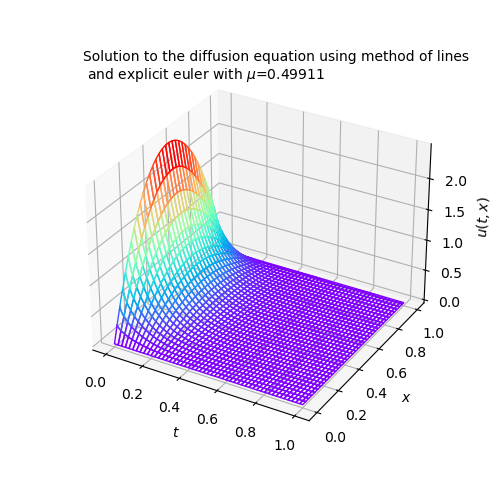

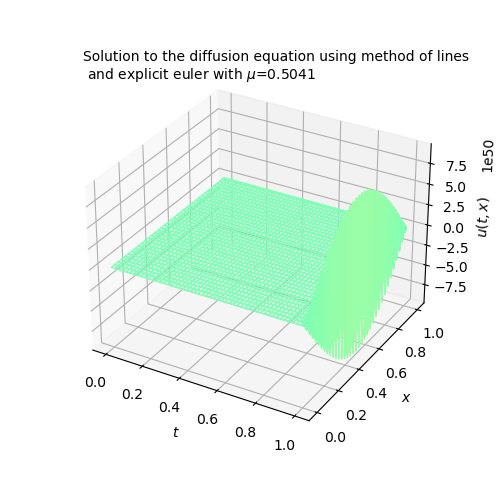

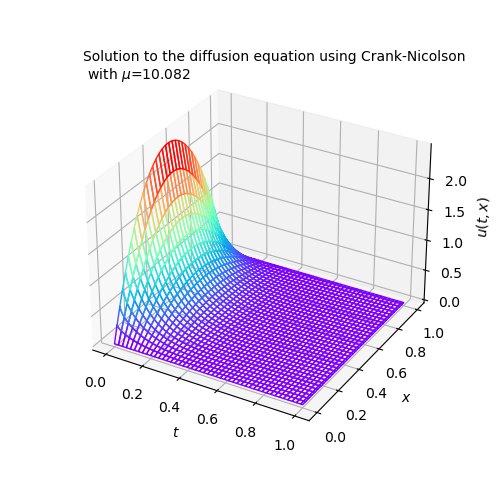

In [5]:
L=1 # x in [0,1]
N=70 # spatial points
Ms=[10100,10000, 500] # time points
tend=1 # t in [0,1]

dx=L/(N+1) 
xx = np.linspace(0,L,N+2) #2 non computational points 
for M in Ms: # we solve for different Ms to experiment with CFL
    dt=tend/M
    tt = np.linspace(0,tend,M+1)

    T,X=np.meshgrid(tt, xx)  # The time and space grid 

    #g= 10*triang(N) #Triangle function
    g= -10*xx*(xx-np.ones(N+2)) # Parabola
    #g=np.exp(-100*((xx-0.5)**2))
    
    u_old= g[1:-1]
    u_sol=np.array([g.tolist()]) #store as nparray([[]]), do this for concatenate
    
    Tdx = Toeplitz(L,N)
    for i in range(0, M): #Timestep M time
        if(M==500):
            u_now=TRstep(Tdx,u_old,dt) 
        else:
            u_now=eulerstep(Tdx,u_old,dt)
            
        u_intermediate = np.insert(u_now, 0, 0, axis=0) #insert boundaries
        u_intermediate= np.append(u_intermediate, [0]) #insert boundaries
        u_intermediate = np.array([u_intermediate.tolist()])

        u_sol=np.concatenate((u_sol,u_intermediate)) # Add U to the solution
        u_old=u_now
    
    u_sol=np.transpose(u_sol) #transposing (Need to match the grid)

    mu=str(round(dt/(dx**2),5))
    if(M==500):
        plot3d(T,X,u_sol,'Solution to the diffusion equation using Crank-Nicolson \n with $\mu$='+ mu,'$t$','$x$','$u(t,x)$')
    else:
        plot3d(T,X,u_sol,'Solution to the diffusion equation using method of lines \n and explicit euler with $\mu$='+ mu,'$t$','$x$','$u(t,x)$')

We observe instability, just as we overshoot the CFL condition. The solution blows up. For Crank Nicolson this does not happen as it uses an implicit time stepping method, which handles the stiffnes.

## 3. The Advection equation

The linear advection equation is

$$
u_{t}+a u_{x}=0,
$$

with appropriate initial and boundary conditions. We will only work with periodic boundary conditions. This means that the solution satisfies $u(t, 0)=$ $u(t, 1)$ for all times $t$. That is, the solution "wraps around" from $x=1$ to $x=0$, and vice versa.

With periodic boundary conditions, we represent the solution $u$ on the entire grid, including the "boundaries" throughout the entire computation. Let the solution vector at time $t$ be an $N$-vector and introduce an equidistant grid on $[0,1]$, such that $0=x_{1}, \ldots, x_{j}=(j-1) \Delta x, \ldots, x_{N}=(N-1) \Delta x$ and $x_{N+1}=1$.

This implies that $\Delta x=1 / N$, and that we are going to compute the solution at the $N$ points $x_{1}, \ldots x_{N}$. The solution at the right boundary, $x_{N+1}=1$, is $u_{N+1}$ and is identified with $u_{1}$ at the left boundary, $x_{1}=0$.
Initial conditions are always needed, and have the form

$$
u(0, x)=g(x)
$$

Note that the initial condition must satisfy $g(0)=g(1)$ and $g^{\prime}(0)=g^{\prime}(1)$ when periodic boundary conditions are used. One of the simplest methods of order 2 for the advection equation is the Lax-Wendroff scheme. It can be derived using a Taylor series expansion. Thus,

$$
u(t+\Delta t, x)=u(t, x)+\Delta t u_{t}+\frac{\Delta t^{2}}{2 !} u_{t t}+\mathrm{O}\left(\Delta t^{3}\right) .
$$

From the differential equation $u_{t}+a u_{x}$ we get $u_{t t}=-a u_{x t}$, as well as $u_{t x}=-a u_{x x}$. Therefore we have $u_{t t}=a^{2} u_{x x}$ provided that the solution $u$ is sufficiently differentiable. Inserting this into the Taylor series expansion we get

$$
u(t+\Delta t, x)=u(t, x)-a \Delta t u_{x}+\frac{a^{2} \Delta t^{2}}{2 !} u_{x x}+\mathrm{O}\left(\Delta t^{3}\right)
$$

This gives the Lax-Wendroff scheme,

$$
u_{j}^{n+1}=\frac{a \mu}{2}(1+a \mu) u_{j-1}^{n}+\left(1-a^{2} \mu^{2}\right) u_{j}^{n}-\frac{a \mu}{2}(1-a \mu) u_{j+1}^{n},
$$

where $\mu=\frac{\Delta t}{\Delta x}$. Note that the method coefficients are not symmetric - instead, they change with the flow direction as determined by the sign of $a$.

We implement a Lax-Wendroff solver for the scalar advection equation with periodic boundary conditions. We write a function `LaxWen(u, amu)` that takes a step of size $\Delta t$ starting from the "initial condition" $u$. The parameter `amu` is the product $a \Delta t / \Delta x$. Because of periodic boundary conditions this will result in a Circulant matrix.

In [7]:
# We construct the circulant matrix representing the Lax-Wendroff Scheme 
# N = nbr of spatial points
def circulantLW(amu, N):
    v = np.array([1-amu**2, (amu/2)*(amu+1)])
    v = np.append(v,np.zeros(N-3))
    v = np.append(v, [(amu/2)*(amu-1)])
    return csr_matrix(circulant([v]))

# one Lax-Wendroff step 
def LaxWen(u, amu):
    return circulantLW(amu, len(u)).dot(u)

We construct a solver for the advection equation.

In [8]:
def soladveq(N,M,L,tend,a, gfunc):
    xx = np.linspace(0,L,N+1) # We have computation point at x=0 but not at x=1 -->N+1 (u_1=u_N+1-> no x_0)
    tt = np.linspace(0,tend,M+1)

    dx = L/N
    dt = tend/M
    mu=dt/dx

    T,X=np.meshgrid(tt, xx)
    g = gfunc(xx)#np.exp(-100*((xx-0.5)**2))

    u_sol = np.array([g.tolist()])
    u_old = g[0:N]
    #matrix = circulantLW(a*mu, N)
    
    for i in range(0,M):
        u_new = LaxWen(u_old,a*mu) #matrix.dot(u_old)
        u_intermediate = np.append(u_new, [u_new[0]])
        u_intermediate = np.array([u_intermediate.tolist()])
        u_sol=np.concatenate((u_sol, u_intermediate))
        u_old=u_new
        
    u_sol=np.transpose(u_sol) #transposing
    return T,X,u_sol, a*mu

We Test the solver using some pulse-like initial data, e.g.

$$
g(x)=\mathrm{e}^{-100(x-0.5)^{2}} .
$$

Note that this function does not satisfy the boundary conditions exactly, but the discrepancy is small enough that it is dominated by the $\mathcal{O}\left(\Delta x^{2}\right)$ error.


0.4


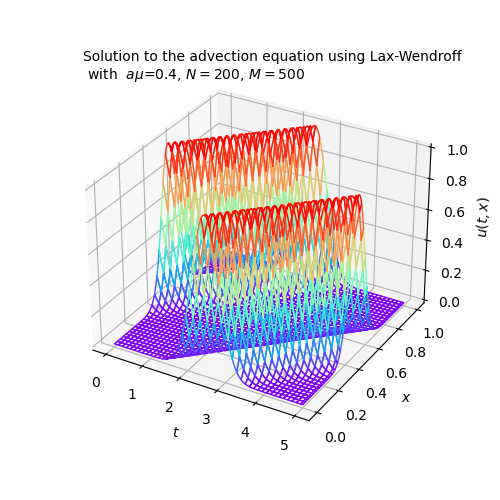

In [9]:
def gfunc(x):
    return np.exp(-100*((x-0.5)**2))

T,X,u_sol, amu = soladveq(200,500,1,5,0.2, gfunc)
amu = str(amu)
print(amu)
plot3d(T,X,u_sol,'Solution to the advection equation using Lax-Wendroff \n with  $a\mu$=' + amu + ", $N=200$, $M=500$",'$t$','$x$','$u(t,x)$')

We check that solver works for negative $a$.

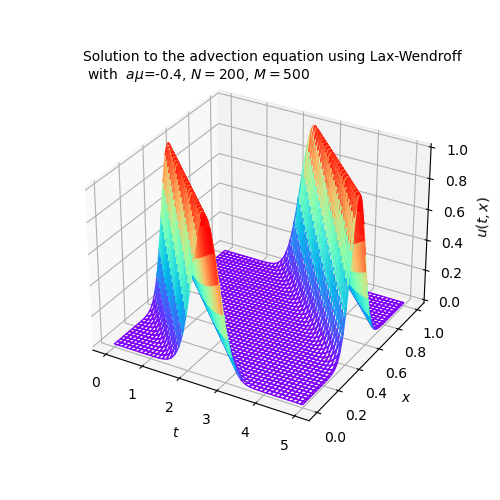

In [10]:
T,X,u_sol, amu = soladveq(200,500,1,5,-0.2, gfunc)
amu = str(amu)
plot3d(T,X,u_sol,'Solution to the advection equation using Lax-Wendroff \n with  $a\mu$=' + amu + ", $N=200$, $M=500$",'$t$','$x$','$u(t,x)$')

We produce plots of the solution for two CFL numbers. In addition we plot the $L^{2}$ norm (RMS norm) of the solution vs time $t \in[0,5]$ for $a \Delta t / \Delta x=1$ as well as for $a \Delta t / \Delta x=0.9$.

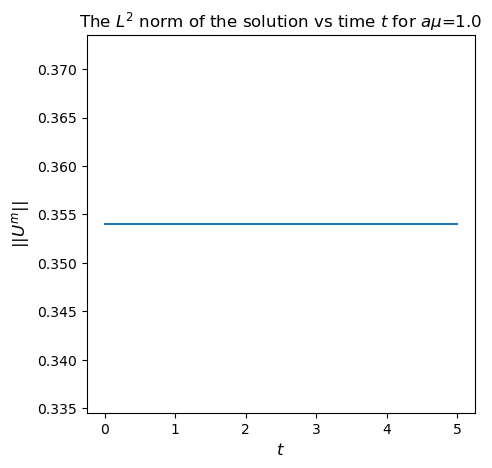

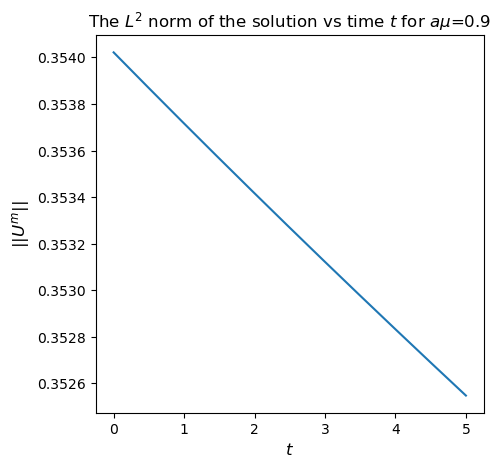

In [11]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.figsize'] = [5, 5]
Ns=[100, 90]
M=500
L=1
tend=5
a=1

for N in Ns:
    T,X,u_sol, amu = soladveq(N,M,L,tend,a, gfunc)
    dx = L/N 
    amu=str(amu)
    
    tt = np.linspace(0,tend,M+1)
    rms = np.array([])
    
    for i in range(0, len(u_sol[0])):
        vector=u_sol[:,i] # since we have transposed we look at each column vector
        vector=vector[0:-1] # We dont use the last boundary point
        rms=np.append(rms, sqrt(mean(square(vector)))) # rms norm

    plt.plot(tt,rms)
    plt.xlabel("$t$", fontsize=12)
    plt.ylabel("||$U^m$||", fontsize=12)
    plt.title("The $L^2$ norm of the solution vs time $t$ for $a\mu$=" +amu );
    #plt.ioff()
    plt.show()

The norm is conserved if $a\mu=1$ since the solution will be exact there (information is transfered along the characteristics exactly as in the exact solution), and the exact solution is conserved (conservation law).

## 4. The convection-diffusion equation

The linear convection-diffusion equation is

$$
u_{t}+a \cdot u_{x}=d \cdot u_{x x}
$$

with appropriate initial and boundary conditions at both boundaries. Here $a$ is the convection velocity, and $d$ is the diffusivity. We introduce an equidistant grid on $[0,1]$ with $\Delta x=1 / N$ and work with periodic boundary conditions only, as we did with the advection equation.

The ratio $\mathrm{Pe}=|a / d|$ is known as the Péclet number. It measures the balance between the convective and diffusive terms. At high Péclet numbers, the solution is convection dominated; for small Pe diffusion dominates.

A straightforward method of lines discretization using the standard secondorder central difference quotients gives

$$
\dot{U}=\left(d \cdot T_{\Delta x}-a \cdot S_{\Delta x}\right) U
$$

where the matrices $T_{\Delta x}$ and $S_{\Delta x}$ need to be adjusted for the periodic boundary conditions. They will be of the circulant type.

It is important to note that due to the diffusion term, this system of ODEs is always stiff. Therefore, it is preferable to work with implicit methods for the time-stepping. In the following task we choose the trapezoidal rule, which is A-stable and second order in time. The A-stability means that we will not have a CFL condition and could take $\Delta t \approx \Delta x$, and the second-order accuracy in both time and space means that for such a choice the temporal error should be of similar size as the spatial error. We write the convection-diffusion solver.

In [13]:
%matplotlib widget
# Takes a single time step carried out by the Trapezoidal rule
# We assume tha the input u is vector with the initial function input and of the correct size.
def convdif(u,a,d,dt,dx):
    #print(1/dx)
    Sdx = Toeplitz(1, int(1/dx), 1, 'periodic')
    Tdx = Toeplitz(1, int(1/dx), 2, 'periodic')
    return TRstep(d*Tdx-a*Sdx,u,dt) #

# Note we work in the interval [0,1] both in time and space
def solconvdif(N,M,a,d, gfunc):
    xx = np.linspace(0,1,N+1) # We have computation point at x=0 but not at x=1 -->N+1 (u_1=u_N+1-> no x_0)
    tt = np.linspace(0,1,M+1)

    dx = 1/N
    dt = 1/M
    pe= np.abs(a/d)
    
    T,X=np.meshgrid(tt, xx)
    g = gfunc(xx)#np.exp(-100*((xx-0.5)**2))

    u_sol = np.array([g.tolist()])
    #u_sol = np.array([g.tolist()[0:N]])
    u_old = g[0:N]
    
    for i in range(0,M):
        u_new = convdif(u_old, a, d, dt, dx) #matrix.dot(u_old)
        u_intermediate = np.append(u_new, [u_new[0]])
        u_intermediate = np.array([u_intermediate.tolist()])
        #u_intermediate = np.array([u_new.tolist()])
        u_sol=np.concatenate((u_sol, u_intermediate))
        u_old=u_new
        
    u_sol=np.transpose(u_sol) #transposing
    return T,X,u_sol, pe

We test our solver

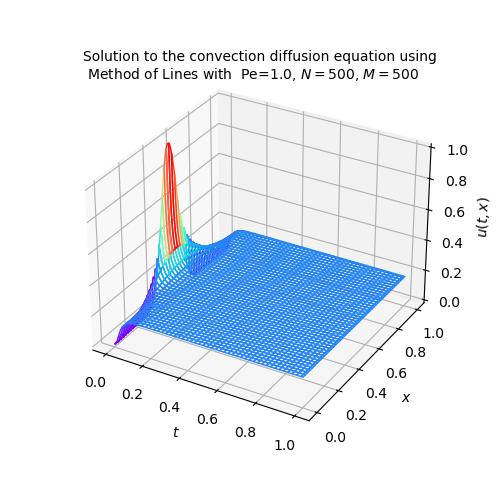

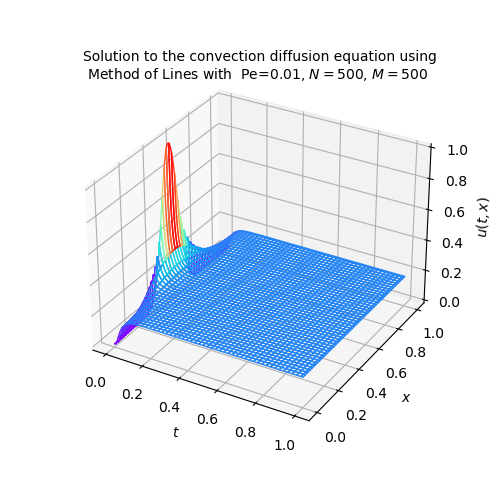

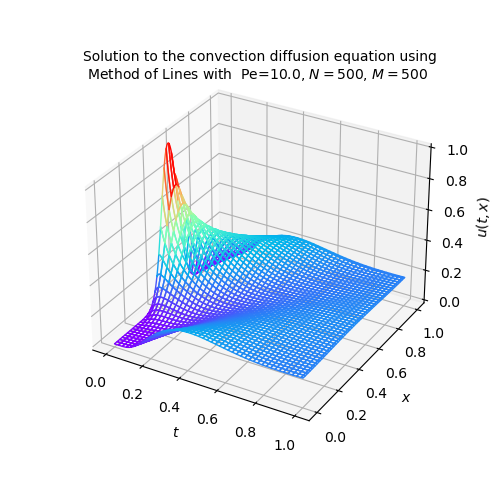

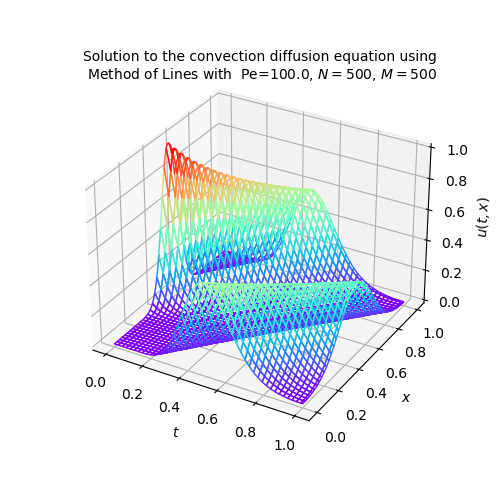

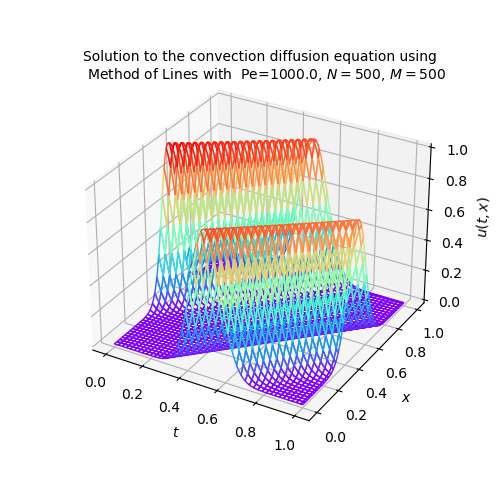

In [14]:
def gfunc(x):
    return np.exp(-100*((x-0.5)**2))
def gfunc2(x):
    return -10*x*(x-1)
def gfunc3(x):
    return skewnorm.pdf(x, a=-2, loc=x[-1]/2, scale=0.3)

ads=[(1,1), (0.01,1), (1,0.1), (1,0.01),(1,0.001)]
for (a,d) in ads:
    T,X,u_sol, pe = solconvdif(500,500,a,d, gfunc)
    pe = str(pe)
    plot3d(T,X,u_sol,'Solution to the convection diffusion equation using \n Method of Lines with  Pe=' + pe + ", $N=500$, $M=500$",'$t$','$x$','$u(t,x)$')

As expected we get a diffusion dominated phenomena with a low Péclet number, and a convection dominated propagation for a high Péclet number. It is worth mentioning even though using an implicit time stepping method you can't choose the spatial stepsize as large as you wish(ignoring accuracy). There is a so called mesh-Péclet condition that is necessary for the discretization to obtain the same properties as the continous, exact problem (essentially that the discrete problem has negative real eigenvalues). One can show that in this particular case the condition would be $|a\Delta x|\leq 2$.

## 5. The viscous Burgers equation 
The viscous Burgers equation is $u_{t}+u u_{x}=d \cdot u_{x x}$. Note that this problem is nonlinear, so a simple matrix-vector representation won't work. It is a nonlinear convection-diffusion equation.

We are going to build a solver for this equation using the tools developed above. However, we are going to find out that due to the nonlinearity the problem is far more complicated than one might think.

To obtain a discretization that is of second order at $d=0$, note that you cannot just replace the advection speed $a$ by $u$ in your Lax-Wendroff solver. Instead, you have to start anew from

$$
u(t+\Delta t, x) \approx u(t, x)+\Delta t u_{t}+\frac{\Delta t^{2}}{2 !} u_{t t} .
$$

Using the inviscid Burgers equation $u_{t}=-u u_{x}$, express $u_{t t}$ in terms of space derivatives $\left(u, u_{x}\right.$ and $\left.u_{x x}\right)$ and replace the time derivatives with these expressions to obtain the Lax-Wendroff discretization of $u_{t}=-u u_{x}$, where all space derivatives are approximated by symmetric finite differences. 

The scheme will look a little more complicated than it did for $u_{t}=-a u_{x}$, and will lead to a recursion `unew = LW(uold)` where you need to construct the map $u \mapsto \operatorname{LW}(\mathrm{u})$, as done below:

In [17]:
# Nonlinear convective part is treated by the explicit Lax Wendroff method
# From the taylor expansion we derive a Lax Wendroff scheme for the inviscid Burgers.
def LW(uold, dt):
    N = len(uold)
    Sdx = Toeplitz(1,N, order=1, Bc='periodic')
    Tdx = Toeplitz(1,N, order=2, Bc='periodic')
    return uold - dt*uold*(Sdx.dot(uold)) + (dt**2/2)*uold*(2*(Sdx.dot(uold))**2+uold*(Tdx.dot(uold)))

We are not going to run this scheme; we first need to add the diffusion term. Because the latter is stiff, we will treat it by the Trapezoidal Rule. This means that we will add the diffusion as follows,

$$
\text { unew }=\mathrm{LW}(\text { uold })+d \cdot \frac{\Delta t}{2}\left(T_{\Delta x} \text { unew }+T_{\Delta x} \text { uold }\right) .
$$

Note that $T_{\Delta x}$ is a circulant matrix to account for the periodic boundary condition. Because the scheme is now implicit, we have to solve for unew, from the linear system

$$
\left(I-d \cdot \frac{\Delta t}{2} T_{\Delta x}\right) \text { unew }=\text { LW }(\text { uold })+d \cdot \frac{\Delta t}{2} T_{\Delta x} \text { uold },
$$
as shown below:

In [18]:
# Here we take the time step and the linear diffusion part is taken care of by the Trapezoidal Rule
def trapBurgers(uold,dt,d):
    N = len(uold)
    lwold = LW(uold,dt)
    Tdx = Toeplitz(1,N, order=2, Bc='periodic')
    I = csr_matrix(np.identity(N))
    return spsolve(I-(d*dt/2)*Tdx, lwold + (d*dt/2)*Tdx.dot(uold))

We have then obtained a simple second order discretization of the viscous Burgers equation, where the nonlinear convective part is treated by the explicit Lax-Wendroff method, and the linear diffusion part is taken care of by the Trapezoidal Rule. Note that while the scheme is second-order convergent, the above reasoning does not constitute a rigorous proof of this fact. For this project, however, we omit such a verification.

We now write a script for the repeated time stepping, where we collect the solution data for plotting.

In [19]:
def solviscBurgers(N,M,d, gfunc):
    xx = np.linspace(0,1,N+1) # We have computation point at x=0 but not at x=1 -->N+1 (u_1=u_N+1-> no x_0)
    tt = np.linspace(0,1,M+1)

    dx = 1/N
    dt = 1/M
    
    T,X=np.meshgrid(tt, xx)
    g = gfunc(xx)#np.exp(-100*((xx-0.5)**2))

    u_sol = np.array([g.tolist()])
    #u_sol = np.array([g.tolist()[0:N]])
    u_old = g[0:N]
    
    for i in range(0,M):
        u_new = trapBurgers(u_old, dt, d) #matrix.dot(u_old)
        u_intermediate = np.append(u_new, [u_new[0]])
        u_intermediate = np.array([u_intermediate.tolist()])
        #u_intermediate = np.array([u_new.tolist()])
        u_sol=np.concatenate((u_sol, u_intermediate))
        u_old=u_new
        
    u_sol=np.transpose(u_sol) #transposing
    return T,X,u_sol

We choose a fairly low diffusivity so that we can see some wave propagation and use the pulse data as an initial condition, but make sure it has a high enough amplitude.

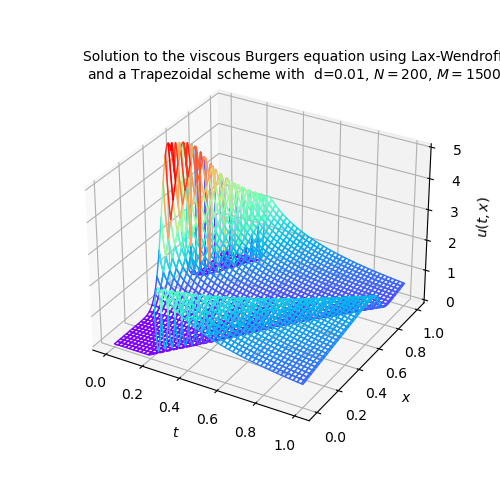

In [20]:
def gfunc(x):
    return 5*np.exp(-100*((x-0.5)**2))
def gfunc3(x):
    return 20*x*(1-x)

T,X,u_sol = solviscBurgers(200,1500,0.01, gfunc)
d = '0.01'
plot3d(T,X,u_sol,'Solution to the viscous Burgers equation using Lax-Wendroff \n and a Trapezoidal scheme with  d=' + d + ", $N=200$, $M=1500$",'$t$','$x$','$u(t,x)$')

Observe the waves with very steep gradients (near shocks)! This happens because the characteristics intersect and means that a classical solution to the PDE does not exist and leads to the formation of a shock wave.